In [1]:
# If you have not already installed the necessary packages:
# pip install climetlab
# pip install maelstrom-a1-a1

## Loading the data


In [2]:
import climetlab as cml

In [3]:
cmlds = cml.load_dataset(
        'maelstrom-a1',
        size='5GB',
        parameter='air_temperature',
        dates=['2020-01-01']
    )

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/metno/maelstrom_a1/LICENSE. If you do not agree with such terms, do not download the data. 


In [4]:
ds = cmlds.to_xarray()
print(ds)

<xarray.Dataset>
Dimensions:             (record: 1, x: 128, y: 128, leadtime: 8, predictor: 49, char: 50)
Coordinates:
  * x                   (x) float32 -2.974e+05 -2.964e+05 ... -1.704e+05
  * y                   (y) float32 -5.043e+05 -5.033e+05 ... -3.773e+05
  * leadtime            (leadtime) timedelta64[ns] 00:00:00 ... 1 days 18:00:00
    latitude            (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude           (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Dimensions without coordinates: record, predictor, char
Data variables:
    time                (record) datetime64[ns] 2020-01-01
    projection          int32 ...
    altitude            (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    predictors          (record, y, x, predictor) float32 dask.array<chunksize=(1, 128, 128, 49), meta=np.ndarray>
    leadtime_predictor  (predictor) timedelta64[ns] dask.array<chunksize=(49,), meta=np.ndarray>
    name_p

## Plotting predictors and predictand (target)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

names = ds["name_predictor"].values
names = np.array([''.join([qq.decode('utf-8') for qq in names[p, :]]) for p in range(names.shape[0])])

num_leadtimes = len(ds["leadtime"])

unique_predictor_names = np.unique(names)
print(unique_predictor_names)


['air_temperature_2m' 'bias_recent' 'bias_yesterday' 'cloud_area_fraction'
 'precipitation_amount' 'x_wind_10m' 'y_wind_10m']


Text(0.5, 1.0, 'Target')

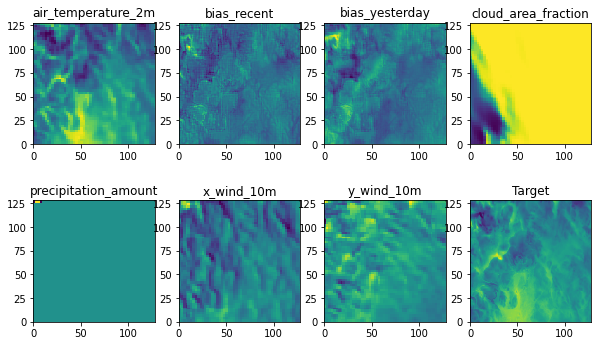

In [6]:
index_date = 0
predictors = ds["predictors"].values
target = ds["target"].values
for i, name in enumerate(unique_predictor_names):
    plt.subplot(2, 4, i + 1)
    index = np.where(names == name)[0][0]
    plt.pcolormesh(predictors[index_date, :, :, index], shading="auto")
    plt.gca().set_aspect(1)
    plt.title(name)
plt.subplot(2, 4, 8)
plt.pcolormesh(target[index_date, :, :, 0], shading="auto")
plt.gca().set_aspect(1)
plt.gcf().set_size_inches(10, 6)
plt.title("Target")

# Example solution
## Normalize predictors

In [7]:
raw = np.copy(ds["predictors"][:, :, :, 0:8])
P = ds["predictors"].shape[3]
for p in range(P):
    ds["predictors"][:, :, :, p] -= np.nanmean(ds["predictors"][:, :, :, p])
    ds["predictors"][:, :, :, p] /= np.nanstd(ds["predictors"][:, :, :, p])

/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/thomasn/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value enc

## Set up the model
The model takes a gridded predictor set as input and outputs gridded fields for each leadtime and for three quantiles. The tempearture forecast on yr.no has both a deterministic best guess and a 10-90% confidence interval. We want the model to predict all three parameters simultaneously.

In [8]:
import keras
import tensorflow as tf
import keras.backend as K

num_outputs = 3 * 8
model = keras.Sequential()
model.add(keras.layers.InputLayer(predictors.shape[1:]))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Conv2D(24, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Dense(num_outputs))

model.compile(optimizer = keras.optimizers.Adam(lr = 1e-2), loss = quantile_loss_function)

2021-07-28 11:03:26.984947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-07-28 11:03:26.984968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-07-28 11:03:27.908455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomasn/local/lib
2021-07-28 11:03:27.908476: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-28 11:03:27.908491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc5088): /proc/driver/nvidia/version d

## Define loss function
We use the quantile loss function, by scoring each of the three output quantiles of the model:

In [55]:
def quantile_loss_function(y_true, y_pred):
    LT = 8
    err0 = y_true - y_pred[:, :, :, 0:LT]
    err1 = y_true - y_pred[:, :, :, LT:(2*LT)]
    err2 = y_true - y_pred[:, :, :, (2*LT):(3*LT)]
    qtloss0 = (0.5 - tf.cast((err0 < 0), tf.float32)) * err0
    qtloss1 = (0.1 - tf.cast((err1 < 0), tf.float32)) * err1
    qtloss2 = (0.9 - tf.cast((err2 < 0), tf.float32)) * err2
    return K.mean(qtloss0 + qtloss1 + qtloss2)

## Train model

In [10]:
model.compile(optimizer = keras.optimizers.Adam(lr = 1e-2), loss = quantile_loss_function)
num_epochs = 50
batch_size = 4
model.fit(predictors, target, epochs=num_epochs, batch_size=batch_size)

2021-07-28 11:03:41.710229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 11:03:41.729309: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 6.8623
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 3.1907
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 2.3636
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 1.9536
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 1.6694
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 1.4803
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 1.2968
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 1.2437
Epoch 9/50
1/1 [==============================] - 0s 17ms/step - loss: 1.1244
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0530
Epoch 11/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0563
Epoch 12/50
1/1 [==============================] - 0s 22ms/step - loss: 0.9823
Epoch 13/50
1/1 [==============================] - 0s 22ms/step

## Predict output

In [13]:
output = model.predict(predictors)

## Visualize results as timeseries
We can visualize the output as a timeseries. We will pick an example point (Oslo).

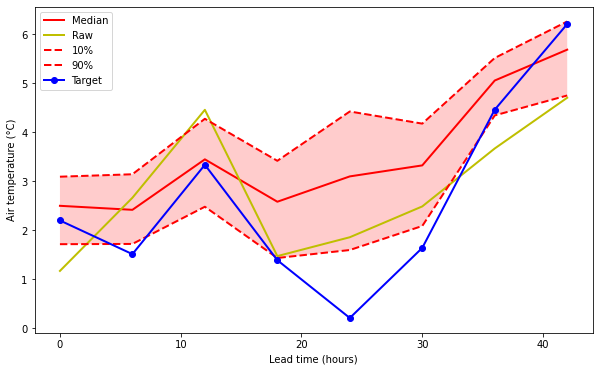

In [53]:
Y = 55
X = 55
plt.plot(x, output[0, Y, X, 0:num_leadtimes], 'r-', lw=2, label="Median")
plt.plot(x, raw[0, Y, X, 0:num_leadtimes], 'y-', lw=2, label="Raw")
lower = output[0, Y, X,num_leadtimes:2*num_leadtimes]
upper = output[0, Y, X, 2*num_leadtimes:3*num_leadtimes]
plt.plot(x, lower, 'r--', lw=2, label="10%")
plt.plot(x, upper, 'r--', lw=2, label="90%")
xx = np.concatenate((x, x[::-1]))
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lower, upper[::-1])), color='r', alpha=0.2, linewidth=0)
plt.plot(x, target[0, Y, X, :], 'bo-', lw=2, label="Target")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Air temperature (°C)")
plt.gcf().set_size_inches(10, 6)

## Visualize results on a map

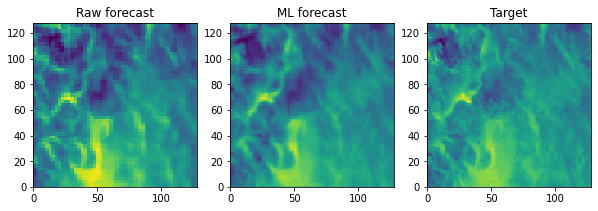

In [47]:
plt.subplot(1, 3, 1)
plt.pcolormesh(raw[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("Raw forecast")

plt.subplot(1, 3, 2)
plt.pcolormesh(output[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("ML forecast")

plt.subplot(1, 3, 3)
plt.pcolormesh(target[0, :, :, 0])
plt.gca().set_aspect(1)
plt.title("Target")
plt.gcf().set_size_inches(10, 6)

## Evaluate

In [17]:
print("Raw model MAE:", np.nanmean(np.abs(raw - target)), "°C")
print("ML MAE:", np.nanmean(np.abs(output[:, :, :, 0:8] - target)), "°C")

Raw model MAE: 0.8423684 °C
ML MAE: 0.6411107 °C


Text(0, 0.5, 'Mean absolute error (°C)')

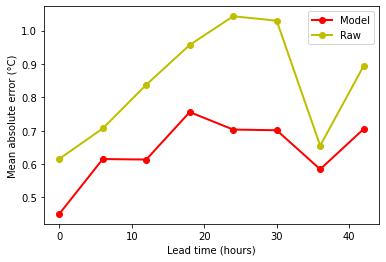

In [46]:
x = ds["leadtime"].astype(float) / 3600 / 1e9
plt.plot(x, [np.nanmean(np.abs(output[:, :, :, i] - target[:, :, :, i])) for i in range(num_leadtimes)], 'ro-', lw=2, label="Model")
plt.plot(x, [np.nanmean(np.abs(raw[:, :, :, i] - target[:, :, :, i])) for i in range(num_leadtimes)], 'yo-', lw=2, label="Raw")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Mean absolute error (°C)")
